# Gesture Recognition
In this group project, we are going to build a 3D Conv model and CNN+RNN model that will be able to predict the 5 gestures correctly. 

In [1]:
#Importing required libraries

import numpy as np
import os
from scipy.misc import imresize,imread
import datetime
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
from keras import backend as K
import cv2

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

batch_size = 32 #experiment with the batch size

In [4]:
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [5]:
#Function to normalize the image
def normalize_img(img):
    normalized_img= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_img

#function to Crop image
def crop_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    return img

#Function to plot loss and accuracy of a model
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
#perform image operations on a specific batch.
def gen_image_batch(source_path, folder_list, batch_size,t,batch,img_idx,augment):
    
    batch_data = np.zeros((batch_size,nb_frames, nb_rows, nb_cols,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    if (augment): batch_data_aug = np.zeros((batch_size,nb_frames, nb_rows, nb_cols,3))
        
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            
            resized_img = imresize(image, (nb_rows,nb_cols))
                    
            batch_data[folder,idx,:,:,0] = normalize_img(resized_img[:, : , 0]) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = normalize_img(resized_img[:, : , 1])#normalise and feed in the image
            batch_data[folder,idx,:,:,2] = normalize_img(resized_img[:, : , 2])#normalise and feed in the image
            
            if (augment):
                    shift = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shift,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    crop=shift[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(crop,(nb_rows,nb_cols,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = normalize_img(resized_img[:, : , 0])
                    batch_data_aug[folder,idx,:,:,1] = normalize_img(resized_img[:, : , 1])
                    batch_data_aug[folder,idx,:,:,2] = normalize_img(resized_img[:, : , 2])
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])        
    
    return batch_data, batch_labels



In [7]:
def generator(source_path, folder_list, batch_size,augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, nb_frames)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield gen_image_batch(source_path, folder_list, batch_size,t,batch,img_idx,augment) #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield gen_image_batch(source_path, folder_list, batch_size,t,batch,img_idx,augment)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam


#### 1. Conv2D + RNN(GRU) model

In [21]:
# Parameters initialization 
nb_rows = 90   # X dimension of the image
nb_cols = 90   # Y dimesnion of the image
nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,5]
nb_classes = 5

# Input
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same')
                          , input_shape=input_shape))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[4], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

#Optimizer
optimiser = Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_37 (TimeDis (None, 30, 45, 45, 16)    448       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 45, 45, 32)    4640      
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 45, 45, 32)    128       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 30, 22, 22, 32)    0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 22, 22, 64)    18496     
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 22, 22, 64)    256       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 30, 11, 11, 64)    0         
__________

#### 2. 3D convolution model

In [11]:
# Parameters initialization
nb_rows = 90   # X dimension of the image
nb_cols = 90   # Y dimesnion of the image
nb_featuremap = [8,16,32,64,128]
nb_dense = [256, 128, 5]

# Input
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)
# Define model
model3D = Sequential()

#layer 1
model3D.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model3D.add(Activation('relu'))
model3D.add(BatchNormalization())
model3D.add(MaxPooling3D(pool_size=(2,2,2)))

#layer 2
model3D.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model3D.add(Activation('relu'))
model3D.add(BatchNormalization())
model3D.add(MaxPooling3D(pool_size=(2,2,2)))

#layer 3
model3D.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model3D.add(Activation('relu'))
model3D.add(BatchNormalization())
model3D.add(MaxPooling3D(pool_size=(2,2,2)))

#layer 4
model3D.add(Conv3D(nb_featuremap[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model3D.add(Activation('relu'))
model3D.add(BatchNormalization())
model3D.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model3D.add(Flatten())

model3D.add(Dense(nb_dense[0], activation='relu'))
model3D.add(BatchNormalization())
model3D.add(Dropout(0.5))

model3D.add(Dense(nb_dense[1], activation='relu'))
model3D.add(BatchNormalization())
model3D.add(Dropout(0.25))

#softmax layer
model3D.add(Dense(nb_dense[2], activation='softmax'))

#Optimizer
optimiser =Adam(lr=0.0002) #write your optimizer
model3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3D.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 90, 90, 8)     656       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 90, 90, 8)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 90, 90, 8)     32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 45, 45, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 45, 45, 16)    3472      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 45, 45, 16)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 45, 45, 16)    64        
__________

In [12]:
#Steps to create model files in given path

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period=1)
                             #, save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [23]:
# Parameters initialization
nb_rows = 90   # X dimension of the image
nb_cols = 90   # Y dimesnion of the image
train_generator_2D = generator(train_path, train_doc, batch_size,augment=True)
val_generator_2D = generator(val_path, val_doc, batch_size)
num_epochs=20

model2D=model.fit_generator(train_generator_2D, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_2D, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = Source path =  Project_data/train ; batch size = 32
32Epoch 1/20



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 136s 6s/step - loss: 1.8113 - categorical_accuracy: 0.2246 - val_loss: 1.4070 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-12-2809_02_04.402490/model-00001-1.81398-0.22247-1.40702-0.43000.h5
Epoch 2/20
21/21 [==============================] - 91s 4s/step - loss: 1.5818 - categorical_accuracy: 0.3313 - val_loss: 1.3084 - val_categorical_accuracy: 0.4375

Epoch 00002: saving model to model_init_2020-12-2809_02_04.402490/model-00002-1.58177-0.33126-1.30844-0.43750.h5
Epoch 3/20
21/21 [==============================] - 83s 4s/step - loss: 1.3817 - categorical_accuracy: 0.4136 - val_loss: 1.1358 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-12-2809_02_04.402490/model-00003-1.38736-0.40867-1.13585-0.50000.h5
Epoch 4/20
21/21 [==============================] - 79s 4s/step - loss: 1.3344 - categorical_accuracy: 0.4336 - val_loss: 1.6084 - val_categorical_accuracy: 0.3125

Epoch 00004

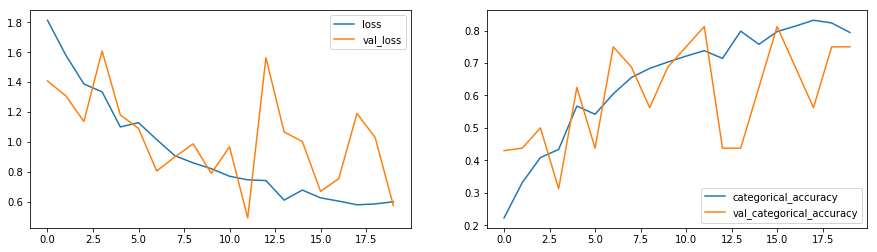

In [24]:
#Visualize loss and accuracy of the model
plot(model2D)

Validation loss was consistently decreasing for each epoch without any huge variation in loss value. Accuracy attained is also good without much overfitting. Model could learn consistently in each epoch.

In [16]:
# Parameters initialization
nb_rows = 90   # X dimension of the image
nb_cols = 90   # Y dimesnion of the image
train_generator_3D = generator(train_path, train_doc, batch_size,augment=True)

val_generator_3D = generator(val_path, val_doc, batch_size)
num_epochs=20

model3D_conv=model3D.fit_generator(train_generator_3D, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_3D, 
                    validation_steps=validation_steps, class_weight=None, workers=2, initial_epoch=0)

Source path =  Project_data/val ; batch size = Source path =  Project_data/train ; batch size = 32
32
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 141s 7s/step - loss: 2.1605 - categorical_accuracy: 0.2682 - val_loss: 1.3184 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-12-2809_02_04.402490/model-00001-2.16882-0.26546-1.31836-0.48000.h5
Epoch 2/20
21/21 [==============================] - 96s 5s/step - loss: 1.4800 - categorical_accuracy: 0.4369 - val_loss: 0.7724 - val_categorical_accuracy: 0.6875

Epoch 00002: saving model to model_init_2020-12-2809_02_04.402490/model-00002-1.47996-0.43685-0.77235-0.68750.h5
Epoch 3/20
21/21 [==============================] - 84s 4s/step - loss: 1.2405 - categorical_accuracy: 0.5162 - val_loss: 1.2421 - val_categorical_accuracy: 0.6250

Epoch 00003: saving model to model_init_2020-12-2809_02_04.402490/model-00003-1.24421-0.51405-1.24215-0.62500.h5
Epoch 4/20
21/21 [==============================] - 77s 4s/step - loss: 1.1305 - categorical_accuracy: 0.5677 - val_loss: 0.9702 - val_categorical_accuracy: 0.7500

Epoch 00004

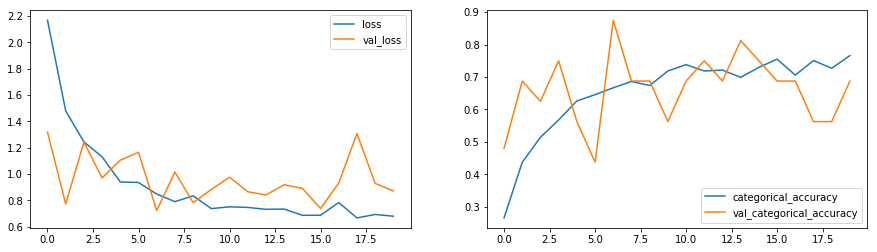

In [17]:
plot(model3D_conv)

Validation loss was oscillating but gradually decreasing in each Epoch.Accuracy attained is also good without any indication of overfitting. Model could learn consistently in each epoch.

#### Summary

Model using **Conv2d+RNN(GRU)**, gave us the best result of train accuracy of **83%** and validation accuracy of **75%** using all the 30 frames and 90*90 image dimension. Cropping did not affect much on the final accurac.Data augmentation helped in attaining a stable model. While we did try various models with different hyperparameters, there was trade off in either Validation accuracy or time and resource consumption. 

Comparatively Conv2d with RNN GRU performed better than Conv3D. The highest validation accuracy without overfitting achieved using Conv3d model was **68%** with train accuracy of **76%**.Hence, GRU is a better choice than Conv3D since it has lesser number of gates and this architecture specifically designed for sequence prediction problems.